In [1]:
import cv2
import sys
import numpy as np
import datetime
import os
import glob
import mxnet as mx
from mxnet import gluon
from skimage import transform as trans
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
import warnings

from retinaface import RetinaFace

ModuleNotFoundError: No module named 'rcnn'

In [ ]:
detector_gpuid = 2
embedder_gpuid = 3

In [ ]:
detector = RetinaFace('./model/R50', 0, detector_gpuid, 'net3')

ctx = mx.gpu(embedder_gpuid)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    embedder = gluon.nn.SymbolBlock.imports("./model/model-r100-ii/model-symbol.json", ['data'], "./model/model-r100-ii/model-0000.params", ctx=ctx)

## Detection & Embedding 관련 함수들

In [5]:
# Todo: make batch version? Maybe it's hard because image sizes can vary?
def detect_faces(detector, image, scales=[1024, 1980], thresh=0.8, flip=False):
    # Validate image array
    assert type(image) is np.ndarray
    assert len(image.shape) == 3  #  W x H x BGR
    assert image.shape[2] == 3  # BGR
    
    im_shape = image.shape
    target_size = scales[0]
    max_size = scales[1]
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])
    #im_scale = 1.0   # Use This if you don't want to scale the original image

    # if im_size_min>target_size or im_size_max>max_size:
    im_scale = float(target_size) / float(im_size_min)
    # prevent bigger axis from being more than max_size:
    if np.round(im_scale * im_size_max) > max_size:
        im_scale = float(max_size) / float(im_size_max)
        
    im_scales = [im_scale]
    
    boxes, landmarks = detector.detect(image, thresh, scales=im_scales, do_flip=flip)
    
    return boxes, landmarks

In [6]:
def resize_and_align_face(image, box, landmark):
    if not hasattr(resize_and_align_face, "_align_src"):
        resize_and_align_face._align_src = np.array([
                [38.2946, 51.6963],
                [73.5318, 51.5014],
                [56.0252, 71.7366],
                [41.5493, 92.3655],
                [70.7299, 92.2041]], dtype=np.float32)
        
    
    box = box.astype(np.int)
    resized_face = cv2.resize(image[box[1]:box[3], box[0]:box[2]], (112, 112))
    
    box_width = box[2] - box[0]
    box_height = box[3] - box[1]
    
    align_dst = landmark
    align_dst[:, 0] -= box[0]
    align_dst[:, 1] -= box[1]
    
    align_dst[:, 0] = align_dst[:, 0] / (box_width / 112.0)
    align_dst[:, 1] = align_dst[:, 1] / (box_height / 112.0)
    
    tform = trans.SimilarityTransform()
    tform.estimate(align_dst, resize_and_align_face._align_src)
    M = tform.params[0:2,:]
    
    aligned_face = cv2.warpAffine(resized_face, M, (112, 112), borderValue = 0.0)
    
    return aligned_face

In [7]:
def embed_face(embedder, ctx, images, batch_size=64):
    for image in images:
        assert image.shape == (112, 112, 3)
    
    batched_images = []
    for idx in range(0, len(image), batch_size):
        batched_images.append(images[idx:idx + batch_size])
    
    embeddings = []
    for batch in batched_images:
        if not batch:
            continue
        input_array = mx.nd.array(batch, ctx=ctx).transpose((0, 3, 1, 2))
        embeddings += list(embedder.forward(input_array).asnumpy())
    
    return embeddings

In [8]:
def box_to_str(box):
    return f"x{box[1]},{box[3]}_y{box[0]},{box[2]}"

## 예제 코드

In [10]:
%%time
for i in range(20):
    print(f"{i}", end="\r", flush=True)
    file_name = 't1'
    file_ext = 'jpg'

    img = cv2.imread(f"{file_name}.{file_ext}")

    boxes, landmarks = detect_faces(detector, img)

    aligned_faces = []
    for box, landmark in zip(boxes, landmarks):
        aligned_faces.append(resize_and_align_face(img, box, landmark))

    embeddings = embed_face(embedder, ctx, aligned_faces)

    document = edict()
    for box, embedding in zip(boxes, embeddings):
        document[f"{file_name}.{file_ext}__" + box_to_str(box.astype(np.int))] = embedding
        
    break  # 이거 주석처리하고 여러개 돌리는 성능 확인. 처음에는 오래 걸림.

CPU times: user 789 ms, sys: 102 ms, total: 892 ms
Wall time: 340 ms


In [11]:
document.keys()

dict_keys(['t1.jpg__x820,1052_y2298,2512', 't1.jpg__x1303,1657_y2363,2637', 't1.jpg__x523,858_y129,428', 't1.jpg__x642,844_y545,721', 't1.jpg__x579,755_y1671,1814', 't1.jpg__x1005,1873_y247,913'])

## 임베딩 벡터들 한번에 거리 계산하기

In [12]:
def get_angular_distances(embs1:np.ndarray, embs2:np.ndarray):
    if type(embs1) is list: embs1 = np.array(embs1)
    elif type(embs1) is mx.ndarray.ndarray.NDArray: embs1 = embs1.asnumpy()
    if type(embs2) is list: embs2 = np.array(embs2)
    elif type(embs2) is mx.ndarray.ndarray.NDArray: embs2 = embs2.asnumpy()
            
    assert len(embs1.shape) == 2 and embs1.shape[1] == 512
    assert len(embs2.shape) == 2 and embs2.shape[1] == 512
    
    dots = np.dot(embs1, embs2.transpose())
    norms1 = np.linalg.norm(embs1, axis=1).reshape((embs1.shape[0], 1))
    norms2 = np.linalg.norm(embs2, axis=1).reshape((1, embs2.shape[0]))
    cos_angle = np.clip(dots / norms1 / norms2, -1.0, 1.0)
    angle = np.arccos(cos_angle)
    
    return angle

In [13]:
embs1 = np.array(embeddings)
embs2 = np.array(embeddings)

In [14]:
embs1.shape, embs2.shape

((6, 512), (6, 512))

In [15]:
distances = get_angular_distances(embs1, embs2)
distances

array([[5.9801998e-04, 1.4638932e+00, 1.5316079e+00, 1.4169375e+00,
        1.5241771e+00, 1.5973431e+00],
       [1.4638932e+00, 0.0000000e+00, 1.6123116e+00, 1.5349239e+00,
        1.3695304e+00, 1.5483751e+00],
       [1.5316079e+00, 1.6123116e+00, 5.9801998e-04, 1.6285679e+00,
        1.3571213e+00, 1.6660100e+00],
       [1.4169376e+00, 1.5349239e+00, 1.6285679e+00, 3.4526698e-04,
        1.6413255e+00, 1.3310080e+00],
       [1.5241771e+00, 1.3695304e+00, 1.3571213e+00, 1.6413255e+00,
        0.0000000e+00, 1.6567705e+00],
       [1.5973431e+00, 1.5483751e+00, 1.6660100e+00, 1.3310080e+00,
        1.6567705e+00, 0.0000000e+00]], dtype=float32)

### 기존 방식과 비교
1쌍 계산에 ~0.3 ms, 36쌍 계산에 ~1 ms, 5776쌍 계산에 ~2 ms

In [17]:
# 기존 방식
def get_angle_between_embeddings(emb1, emb2):
    return np.arccos(np.dot(emb1, emb2) / np.linalg.norm(emb1) / np.linalg.norm(emb2))

In [18]:
%%time
get_angle_between_embeddings(embs1[3], embs2[2])

CPU times: user 212 µs, sys: 163 µs, total: 375 µs
Wall time: 280 µs


1.6285679

In [19]:
%%time
get_angular_distances(embs1, embs2)[3][2]

CPU times: user 456 µs, sys: 351 µs, total: 807 µs
Wall time: 637 µs


1.6285679

## 임베딩 거리를 이용한 실제 분류 과정

In [45]:
def get_pairs_from_distance(distances, threshold=1.1):
    distances = distances + 10 * (np.triu(np.ones_like(distances)) == 0)
    return np.argwhere(distances < threshold)

In [23]:
get_pairs_from_distance(distances, threshold=1.0)

array([], shape=(0, 2), dtype=int64)

In [28]:
# threshold 값을 낮추면 Precision이 대부분의 경우 올라가고, Recall이 확실히 줄어듬.
len(get_pairs_from_distance(distances, threshold=1.0)), len(get_pairs_from_distance(distances, threshold=1.2))

(0, 0)

In [31]:
for pair in get_pairs_from_distance(distances, threshold=1.0):
    box0 = boxes[pair[0]]
    box1 = boxes[pair[1]]
    
    print(f"Angular Distance: {distances[pair[0]][pair[1]]}")
    
    plt.subplot(1, 2, 1)
    plt.imshow(aligned_faces[pair[0]])
    plt.subplot(1, 2, 2)
    plt.imshow(aligned_faces[pair[1]])
    plt.show()

## 디텍션 결과 확인 유틸리티

In [29]:
def visualize_detection(image, boxes, landmarks):
    for box, landmark in zip(boxes, landmarks):
        # print('score', box[4])
        box = box.astype(np.int)
        #color = (255,0,0)
        color = (0,0,255)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)
        
        landmark = landmark.astype(np.int)
        for l in range(landmark.shape[0]):
            color = (0,0,255)
            if l==0 or l==3:
                color = (0,255,0)
            cv2.circle(image, (landmark[l][0], landmark[l][1]), 1, color, 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image[...,::-1])
    plt.show()
    cv2.imwrite('./detection_result.jpg', image)

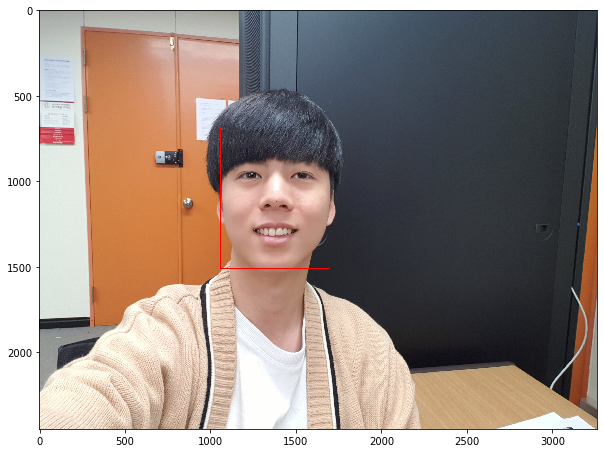

In [32]:
file_name = 'jy1'
file_ext = 'jpg'

img = cv2.imread(f"{file_name}.{file_ext}")
boxes, landmarks = detect_faces(detector, img)

visualize_detection(img, boxes, landmarks)

# 장난감
file1과 file2에 원하는 이미지 경로를 넣으세요! 각 사진에서 비슷한 얼굴들을 뽑아줍니다!

In [30]:
file1 = "t1.jpg"
file2 = "jy1.jpg"
thresh = 1.1

img1 = cv2.imread(file1)
img2 = cv2.imread(file2)

In [31]:
%%time
# Detecting & Embedding
boxes1, landmarks1 = detect_faces(detector, img1, flip=True)

aligned_faces1 = []
for box, landmark in zip(boxes1, landmarks1):
    aligned_faces1.append(resize_and_align_face(img1, box, landmark))

embeddings1 = embed_face(embedder, ctx, aligned_faces1)
embs1 = np.array(embeddings1)


boxes2, landmarks2 = detect_faces(detector, img2)

aligned_faces2 = []
for box, landmark in zip(boxes2, landmarks2):
    aligned_faces2.append(resize_and_align_face(img2, box, landmark))

embeddings2 = embed_face(embedder, ctx, aligned_faces2)
embs2 = np.array(embeddings2)

CPU times: user 2.47 s, sys: 4.22 s, total: 6.7 s
Wall time: 13.3 s


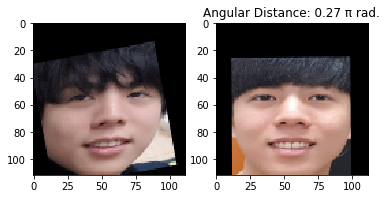

In [47]:
# Result
distances = get_angular_distances(embs1, embs2)
#print(distances)

for pair in get_pairs_from_distance(distances, threshold=thresh):
    box1 = boxes1[pair[0]]
    box2 = boxes2[pair[1]]
    
    #print()
    plt.subplot(1, 2, 1)
    plt.imshow(aligned_faces1[pair[0]][..., ::-1])
    plt.subplot(1, 2, 2)
    plt.imshow(aligned_faces2[pair[1]][..., ::-1])
    plt.title(f"Angular Distance: {distances[pair[0]][pair[1]] / np.pi:.2f} π rad.")
    plt.show()